<a href="https://colab.research.google.com/github/MisterGusMan/Alura_ImersaoDados3/blob/main/An%C3%A1lise_Aula_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta é a última aula do evento, onde criaremos modelos de Machine Learning para prever resultados futuros utilizando os resultados já existentes. Os tópicos desta análise são mais complicados do que as últimas, então trechos das aulas foram colocados no notebook para facilitar a compreensão.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
sns.set_style('darkgrid')

url_dados = 'https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_experimentos.zip?raw=true'

df = pd.read_csv(url_dados, compression = 'zip')
df.rename(columns={'droga':'composto'}, inplace=True)
df.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
dfr = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/imersaodados3/main/dados/dados_resultados.csv')
dfr['n_moa'] = dfr.drop('id', axis=1).sum(axis=1)
dfr['ativo_moa'] = (dfr['n_moa'] != 0)

Utilizando a nossa base de dados ```combinado```, o primeiro problema que pensamos em resolver é: **dado os experimentos, queremos saber se qualquer mecanismo de ação foi ativado ou não ativado.** Ou seja, este caso é um problema de classificação binária.

Mas, também podemos pensar se **dado os experimentos, queremos saber se um determinado mecanismo de ação foi ativado, recebendo como resposta, o composto relacionado**. E aqui, temos um problema de classificação multiclasse, já que cada composto químico é considerado uma classe diferente. 

In [5]:
combinado = pd.merge(df, dfr[['id','n_moa', 'ativo_moa']], on='id')
combinado.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True


Mas, na nossa base ```dfr``` nós encontramos o ID do composto e quais mecanismos de ação foram acionados por determinado experimento. Aqui, como um composto pode acionar mais de um mecanismo, nós teremos uma classificação multilabel (quando uma única instância pode ter mais de uma classe associada) e, através de um algoritmo de Machine Learning nós também podemos resolver este problema: **não somente ter como retorno se um mecanismo de ação foi ativado mas qual ou quais são estes mecanismos**.

É importante lembrar que nossas bases de dados estão separadas com um propósito. A segunda ```dfr``` é como se fosse a resposta da primeira e foi construída por cientistas que analisaram o efeito de um determinado composto nos mais de 700 genes. Esse conhecimento, virou uma base de dados com o passar dos anos e é fruto de análise científica.

E o papel de um modelo de ML neste caso é, a partir de todo esforço humano empenhado por vários anos para entender e tabular qual efeito de um composto quimíco em uma determinada expressão gênica, ser treinado e aprender, ou seja, ser capaz de produzir resultados compatíveis com aqueles feitos pelos(as) próprios(as) cientistas.

Aqui na imersão, vamos começar resolvendo o problema menos complexo, a classificação binária: **dado os experimentos, queremos saber se QUALQUER mecanismo de ação foi ativado ou não**. Basicamente, queremos que o modelo faça predições compatível com a última coluna da nossa base de dados ```combinado```, a ```ativo_moa```.

In [6]:
dfr.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,ativo_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True


As etapas lógicas do nosso processo é:

    Dado um composto -> temos a nossa assinatura celular (```g e c```) -> analisamos o(s) mecanismo(s) de ação ativados (MoA) 

Mas, a nossa pergunta a ser respondida é, **"Dado um composto e uma assinatura celular, houve algum MoA ativado?"** Então, as etapas lógicas passam a ser:

    Composto -> assinatura celular -> MoA ativado?

E como nosso modelo vai aprender a partir da nosa base de dados?

    Composto 1 -> Assinatura A -> MoA = 1
    Composto 2 -> Assinatura B -> MoA = 0
    Composto 3 -> Assinatura C -> MoA = 1
    ...
    Composto N -> Assinatura N -> MoA = 0

Ou seja, toda a nossa base de dados ```combinado``` será a fonte de aprendizado do nosso modelo. Onde, cada experimento (linha) representa um exemplo (assinatura) já que temos a reunião de todas as informações necessárias para criar a nossa classificação binária e, terá como variável resposta, também chamada de target, a coluna ```ativo_moa```, uma variável binária (0, 1).

E, por fim, o nosso modelo deverá ser capaz de resolver o seguinte problema:
  
    Composto candidato -> Assinatura X -> MoA = 1 OU MoA = 0?

Existem diversas técnicas de ML que são capazes de solucionar o nosso problema mas aqui, vamos usar a **Regressão Logística** e, essa técnica já está implementada em uma biblioteca bastante usada e bem importante para ML no Python, o [Scikit-Learn](https://scikit-learn.org/stable/).

Clicando em "Classification" na página inicial, encontramos, no primeiro capítulo, chamado "Linear Models", o nosso subtítulo de interesse: [**"1.1.11 Logistic Regression"**](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).


Quando implementamos um modelo de classificação, precisamos separar a nossa base de dados em base de treino e base de teste. A base de treino, vai ser onde o nosso modelo vai aprender e, a base de teste serve para a verificação do aprendizado do modelo, ou seja, poderemos entender se, de fato, as previsões do nosso modelo estão de acordo com o esperado. 

Não podemos treinar e testar o modelo com o mesmo conjunto de dados porque, seria muito mais fácil dele prever corretamente. A base de dados de teste, funciona como um novo conjunto onde poderemos medir o quanto o nosso modelo está acertando, dado que já temos a variável resposta real.

Para fazer esta divisão, usamos uma função do Scikit-Learn chamada ```train_teste_split``` (como já aprendemos, para usar uma biblioteca ou função, precisamos, primeiramente, fazer a importação padrão e, neste caso, usaremos ```from sklearn.model_selection import train_test_split```).

Para fazer a divisão da base de dados, é necessário definir qual será o nosso ```x``` e o nosso ```y```. Um modelo matemático, define um ```y``` em função de um ```x```, ou seja, ```f(x) = y```. Neste projeto, o nosso ```y``` será o target, ```ativo_moa``` e, ele será definido a partir de uma assinatura (conjunto composto por ```g``` + ```c``` ou , expressão gênica + viabilidade celular).

Assim, teremos: 

    x = combinado.select_dtypes('float64')  ->  toda a base de dados que tem os valores com o formato, ```float64```, no nosso caso, todas as variáveis ```g``` e ```c```

    y = combinado['ativo_moa']  ->  apenas a coluna target, ou seja, ```ativo_moa```

Para o ```train_test_split``` definiremos:
    
    x_treino, x_teste, y_treino, y_teste

E a função receberá como parâmetro:

    train_test_split(x, y, test_size = 0.2)

Onde, 

    x -> base de dados definida como x, no nosso caso, todas as variáveis g e c

    y -> variável resposta, no nosso caso, ativo_moa

    teste_size = 0.2 -> tamanho que definimos para a base de teste

A proporção entre treino e teste, varia de acordo com o volume de dados que temos. Mas, usualmente, encontramos proporções 30/70, 25/75 ou 20/80. Aqui, definimos como 0,2 ou 20%, isso significa que a base de treino será composta pelos 80% restante.



In [7]:
from sklearn.model_selection import train_test_split

x = combinado.select_dtypes('float64')
y = combinado['ativo_moa']

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2)

Agora, podemos fazer a nossa primeira regressão logística.

O primeiro passo, é definir o nosso ```x```, ```y``` e o ```x_treino, x_teste, y_treino, y_teste``` do ```train_test_split```.

Após isso, definimos um nome para o nosso modelo (```modelo_rlogistica```) e declaramos a função ```LogisticRegression()```. Acrescentamos um parâmetro ```max_iter = 1000``` no modelo para que ele seja capaz de convergir para um resultado e assim, não recebemos nenhum warning no resultado.

Em seguida, ajustamos o modelo com o ```.fit(x_treino, y_treino)``` (lembrando que os argumentos desta função são ```x``` e ```y``` e, usamos ```x_treino``` e ```y_treino``` porque será através dessas bases que o algoritmo aprenderá).

E, por fim, usamos a função ```.score(x_teste, y_teste)``` para verificar como o nosso modelo ajustado está se saindo nos dados de teste. O ```score()```calcula a acurácia, ou seja, quantas predições o nosso modelo acertou na base de teste.

Como resultado, temos o valor da acurácia: ~0,627. Então, concluímos que o nosso modelo está acertando ~62% das previsões (caso tivéssemos 100 experimentos, o modelo acertaria 62 casos e erraria 38 casos).

Mas, como podemos estabelecer se este é um bom valor de acurácia ou não?

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x = combinado.select_dtypes('float64')
y = combinado['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_rlogistica = LogisticRegression(max_iter=1000)
modelo_rlogistica.fit(x_treino, y_treino)
modelo_rlogistica.score(x_teste, y_teste)

0.6264959059416334

Para estabelecer se temos um bom valor de acurácia, precisamos de uma base comparativa, quer dizer, preciso dos resultados de um outro modelo para entender se estamos acertando mais ou menos casos.

Para isso, o Scikit-Learn, já tem implementado alguns algoritmos que fazer modelos menos complexos e que podem ser usados como base comparativa. Neste caso, vamos usar o ```DummyClassifier```.

O processo para ajustar este modelo é muito parecido com aquele que usamos para a regressão logística: dividimos a base em treino e teste, definimos um nome para esse modelo e o instanciamos, o ajustamos com os dados de treino e, ao final, verificamos a acurácia com o conjunto teste.

Ao instanciarmos o ```DummyClassifier```, precisamos definir a estratégia que ele usará para fazer o ajuste do modelo. No nosso caso, definimos a estratégia será os dados mais frequentes, isso quer dizer que: dado o valor mais frequente da nossa variável resposta (```ativo_moa```), o modelo Dummy vai chutar que todos os eventos da base de dados assumem aquele valor no target. Assim, temos: ```DummyClassifier('most_frequent')```.

Nesse momento, para calcular a acurácia, vamos usar outra estratégia, a função ```accuracy_score``` também do Scikit-Learn. Ela receberá como parâmetros a base teste da variável resposta (```y_teste```) e as previsões do modelo que, até o momento ainda não calculamos.
Para calcular as previsões, usamos o ```.predict()``` da mesma biblioteca que, receberá como parâmetro a base ```x_teste```.
Por fim, o cálculo da acurácia será: 

    previsao_dummy = modelo_dummy.predict(x_teste)
    accuracy_score(y_teste, previsao_dummy)

A acurácia do ```DummyClassifier```foi de ~60,7%, isso significa que nosso modelo ```LogisticRegression``` teve um desempenho um pouco melhor.

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

modelo_dummy = DummyClassifier('most_frequent')
modelo_dummy.fit(x_treino, y_treino)
previsao_dummy = modelo_dummy.predict(x_teste)
accuracy_score(y_teste, previsao_dummy)

0.6067604450976275

In [10]:
from sklearn.tree import DecisionTreeClassifier


x = combinado.select_dtypes('float64')
y = combinado['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_arvore = DecisionTreeClassifier(max_depth = 3)
modelo_arvore.fit(x_treino, y_treino)
modelo_arvore.score(x_teste, y_teste)

0.6105395758975436

Agora, vamos entender melhor como funciona uma árvore de decisão e o que significa o parâmetro ```max_depth = 3```. 
Plotamos uma imagem que representa o nosso modelo e, nesse momento, é importante que você não se apegue ao código que usamos para isso. O que realmente é relevante é entender o algoritmo!

A figura é dividida em 4 níveis e, o primeiro nível (estamos considerando a orientação de cima para baixo), é composto por apenas um quadro que é chamado de **nó raíz** ou somente **raíz** e ele tem como regras, os melhores atributos que podem dividir a nossa base de dados em dois conjuntos distintos (lembrando que nosso objetivo é separar a nossa base de dados em **mecanismo de ação ativado ou não ativado**).

Entre o primeiro e o segundo nível (e nos demais níveis), temos duas setas: uma para a direita e outra para a esquerda. Essas setas são chamadas de **ramos** e subdividem o nível acima em dois outros conjuntos que separam novamente os dados em **mecanismo de ação ativado ou não ativado**, a partir de uma decisão.

O último nível da árvore (mais abaixo), apresenta n quadros que apresentam características que devem ser levadas em conta na hora da classificação e se dividem em ```class = ativado``` e ```class = não ativado```. Esse nível não apresenta mais ramificações e, esses quadros são chamados de **folhas**.

Se reparmos, a nossa árvore tem 3 níveis de decisão a partir da raíz e é exatamente isso que o parâmetro ```max_depth```representa: a profundidade da árvore.

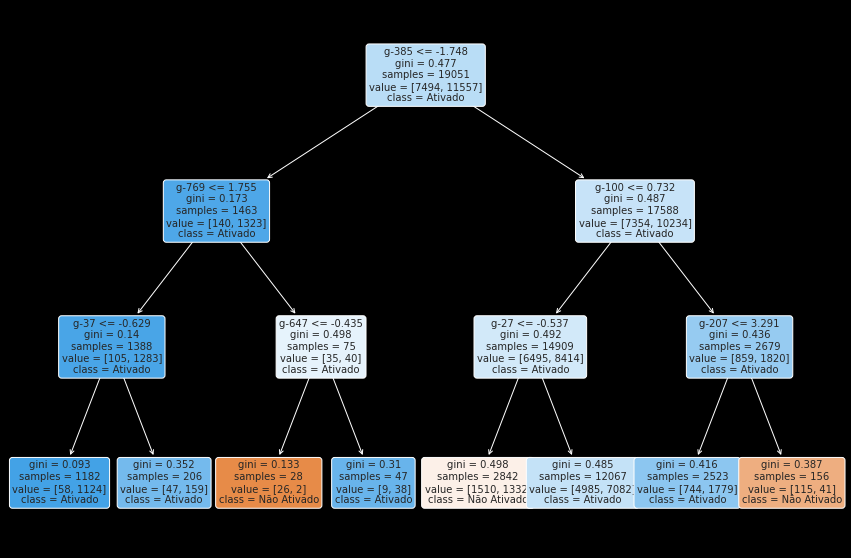

In [11]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(15, 10), facecolor='k')
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=10,
               rounded=True,
               filled=True,
               feature_names=x_treino.columns,
               class_names=['Não Ativado', 'Ativado'])
plt.show()

Como vimos, o desempenho do nosso novo modelo com apenas 3 camadas de decisão não foi tão satisfatório assim. Por isso, vamos variar o ```max_depth``` dentro de um intervalo de valores (range) e comparar os resultados obtidos. 

O processo para obter os valores que queremos, é sempre o mesmo. Por isso, vamos criar um loop ou um laço de repetição (um loop, executa um bloco de código em repetição enquanto uma condição é atendida). 

Então, após fazermos a separação da base de dados em ```x``` e ```y``` e dividí-las no ```train_test_split```, vamos criar um ```for``` para que nosso modelo seja treinado e testado em repetição dentro de um range. Para isso, faremos:

    teste=[]  ->  criando lista para armazenar os resultados da acurácia nos dados de teste 
    treino=[]  ->  criando lista para armazenar os resultados da acurácia nos dados de treino 
    for i in range(1,15):  ->  estabelecendo condição que deve ser atendida (i) e range de valor (range(1, 15))
        modelo_arvore = DecisionTreeClassifier(max_depth = i)  ->  instanciando modelo que será treinado e definindo max_depth = i, ou seja, estamos variando a profundidade da nossa árvore
        modelo_arvore.fit(x_treino, y_treino)  ->  ajustando o modelo a partir das bases de treino
        teste.append(modelo_arvore.score(x_teste, y_teste))  ->  armazenando os resultados de acurácia de teste dos modelos produzidos na lista 'teste'
        treino.append(modelo_arvore.score(x_treino, y_treino))  ->  armazenando os resultados de acurácia de treino dos modelos produzidos na lista 'treino'

In [12]:
from sklearn.tree import DecisionTreeClassifier


x = combinado.select_dtypes('float64')
y = combinado['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

teste=[]
treino=[]
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth = i)
    modelo_arvore.fit(x_treino, y_treino)
    teste.append(modelo_arvore.score(x_teste, y_teste))
    treino.append(modelo_arvore.score(x_treino, y_treino))

Quando chamamos as saídas do nosso ```for``` (```teste``` e ```treino```), podemos observar um comportamento um pouco estranho: enquanto nos dados de teste, o valor da nossa acurácia vai caindo, nos dados de treino, esse valor vai aumentando.

In [13]:
teste

[0.6067604450976275,
 0.6067604450976275,
 0.6105395758975436,
 0.6204073063195465,
 0.6212471131639723,
 0.6185177409195884,
 0.62019735460844,
 0.6204073063195465,
 0.6162082720974176,
 0.6151585135418853,
 0.6134788998530338,
 0.5992021834977955,
 0.5977325215200504,
 0.5977325215200504]

In [14]:
treino

[0.6066348223190384,
 0.6066348223190384,
 0.6211222508004829,
 0.6360820954280615,
 0.6412261823526324,
 0.6489423127394888,
 0.6605427536612252,
 0.6707259461445594,
 0.689570101307018,
 0.706892026665267,
 0.7293055482651829,
 0.7531363183035011,
 0.7768621069760118,
 0.7992756285759278]

Para investigar o que aconteceu, vamos plotar um gráfico para entender o comportamento combinado dessas listas.

Usaremos o ```lineplot``` do Seaborn para construir essa visualização. 
Como parâmetros, teremos: 

    x = range(1, 15)   ->  intervalo que usamos no for
    y = teste e y = treino  ->  listas criamos no for e será usada no eixo y do gráfico
    label = 'teste' e label = 'teste'  ->  etiqueta para identificar as duas linhas que estarão no gráfico 

Observando o gráfico produzido, podemos perceber que, inicialmente, os valores de treino e teste são muito próximos mas, conforme vamos aumentando o range, o valor da acurácia para os dados de treino aumentam muito enquanto, esse mesmo valor para os dados de teste, vai caindo (as linhas vão se afastando).

Isso significa que, conforme aumentamos a profundidade da nossa árvore de decisão, a classificação para os dados de treino ficam muito boas pois, ela consegue captar muito bem as características desses dados. Mas, em contrapartida, o modelo fica tão bom os dados de treino que, quando apresentamos um novo conjunto de dados (teste), ele não consegue generalizar tão bem e assim, temos uma acurácia em queda.

Esse problema de um modelo com performance muito boa nos dados de treino mas performance em queda nos dados de teste, é muito conhecido na ciência de dados e chamamos de **overfitting**.

Então, conseguimos perceber que, para melhorar o nosso modelo, não é suficiente somente aumentar a profundidade da árvore de decisão e assim, precisamos traçar uma outra etratégia para melhorar a performance do nosso modelo.

Nesse momento, vamos testar uma nova técnica de modelagem: o Random Forest. 
O que este modelo faz é criar várias árvores de decisões na qual ele considera amostras aleatórias do nosso conjunto total.  

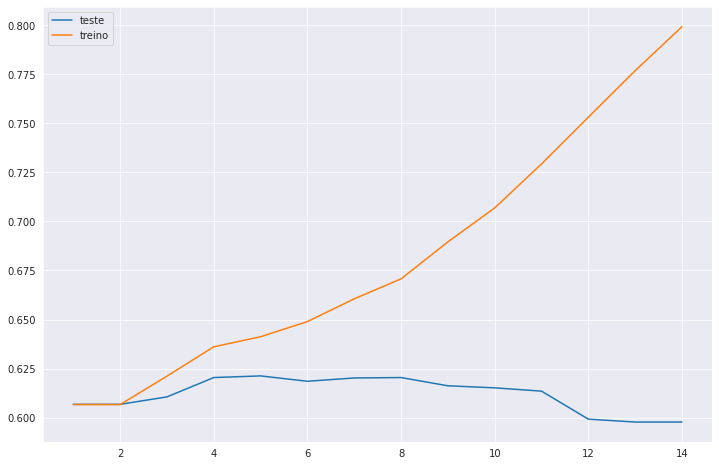

In [15]:
sns.lineplot(x=range(1,15), y = teste, label='teste')
sns.lineplot(x=range(1,15), y = treino, label='treino')

A função que treina um modelo de Random Forest (```RandomForestClassifier()```) não aceita que tenhamos variáveis em formato de string. 
Por isso, precisamos tratar as variáveis que são strings e transformá-las em números (ou no formato float64).

Para fazer essa transformação, vamos usar uma função do Pandas, chamada ```get_dummies``` e nela, declaramos a coluna que queremos que seja transformada. Por exemplo, aqui, usamos:

    pd.get_dummies(combinado['tratamento'])

Isso porque, nossa intenção é transformar a coluna ```tratamento``` da base ```combinado``` em dados numéricos.

Para fazer a transformação desejada, o ```get_dummies``` pega todas as categorias de uma variável e as transforma em novas colunas binárias. 
Por exemplo:

A variável ```tratamento``` apresenta duas categorias ```com_controle``` e ```sem_controle```. Quando aplicamos o ```get_dummies```, ele cria duas novas colunas binárias e análogas as categorias. 
Se temos um evento que apresentava na coluna original a marcação ```com_droga```, agora ela apresentará valor 0 na coluna ```com_controle``` e valor 1 na coluna ```com_droga``` e vice-versa.


In [16]:
pd.get_dummies(combinado['tratamento'])

,com_controle,com_droga
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
23809,0,1
23810,0,1
23811,1,0
23812,0,1


Agora que entendemos como o ```get_dummies``` funciona, podemos transformar todas as nossas variáveis de interesse: ```tratamento```, ```dose``` e ```tempo```.

Para isso, declaramos a base de dados completa e, no parâmetro ```columns```, listamos as variáveis que devem ser transformadas. Assim teremos:

    pd.get_dummies(combinado, columns=['tratamento', 'dose', 'tempo'])

In [17]:
pd.get_dummies(combinado, columns=['tratamento', 'dose', 'tempo'])

,id,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,tratamento_com_controle,tratamento_com_droga,dose_D1,dose_D2,tempo_24,tempo_48,tempo_72
0,id_000644bb2,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,...,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True,0,1,1,0,1,0,0
1,id_000779bfc,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,...,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,0,1,1,0,0,0,1
2,id_000a6266a,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,...,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,0,1,1,0,0,1,0
3,id_0015fd391,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,...,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,0,1,1,0,0,1,0
4,id_001626bd3,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,...,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,-0.1736,0.3686,-0.1565,...,-0.6158,-0.2977,0.0992,0.6838,0.5259,0.7882,0.3119,-0.7697,0.

Aqui, estamos estabelecendo qual será a base de dados usada para modelar o novo algoritmo. Agora, não mais consideraremos apenas os dados genéticos, também levaremos em conta as demais variáveis, exceto as seguintes variáveis:

    'id'  ->  não será relevante nesse momento pois é somente um número de identificação
    'n_moa'  ->  não será relevante nesse momento pois é a quantidade de MoAs ativados
    'ativo_moa'  ->  retiramos da base pois é a nossa variável resposta
    'composto'  ->  não será relevante nesse momento pois identifica o composto usado e foge do que estamos buscando fazer

Para retirar essas variáveis da nossa base de dados, usamos a função ```drop```, declaramos as variáveis a serem retiradas em forma de uma lista e identificamos que são colunas através do parâmetro ```axis = 1```.

In [18]:
combinado.drop(['id', 'n_moa', 'ativo_moa', 'composto'], axis=1)

,tratamento,tempo,dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,com_droga,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,com_droga,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,com_droga,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,com_droga,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,com_droga,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,com_droga,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320

Enfim, podemos partir para o ajuste do nosso modelo de Random Forest.

Novamente, vamos seguir as mesmas etapas lógicas anteriores. Entretando, precisamos modificar o a nossa base ```x```. 
Então faremos: 

    x = combinado.drop(['id', 'n_moa', 'ativo_moa', 'composto'], axis=1)  ->  base de dados de deve ser considerada com a exclusão das colunas que determinamos anteriormente
    x = pd.get_dummies(x, columns=['tratamento', 'dose', 'tempo'])  ->  a partir do x definido acima, fazemos a transformação com o get_dummies nas colunas com o formato de string

Por fim, temos como retorno uma acurácia de ~68,0% e, ela é, aproximadamente, 7% melhor que a acurácia que conseguimos com o ```DummyClassifier```. Aqui, não podemos comparar com a regressão logística porque estamos considerando um outro conjunto de dados. 

É muito importante ressaltar que, apesar de termos melhorado a acurácia do nosso modelo, pensando na vida real, talvez a nossa melhora ainda não seja suficiente. Ou seja, desenvolvemos um modelo com um algoritmo de Machine Learning mas, ele ainda não é aplicável à vida real (isso quer dizer que, ainda não nos traz ganhos suficientes para sua implantação).


In [19]:
from sklearn.ensemble import RandomForestClassifier


x = combinado.drop(['id', 'n_moa', 'ativo_moa', 'composto'], axis=1)
x = pd.get_dummies(x, columns=['tratamento', 'dose', 'tempo'])
y = combinado['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(x_treino, y_treino)
modelo_randomforest.score(x_teste, y_teste)

0.6836027713625866

Agora que conhecemos os diferentes métodos de Machine Learning, podemos responder os desafios desta aula.

#Desafio 01: Tente outros modelos ou mude os parâmetros dos modelos que testamos em aula.

Para responder este desafio, vamos utilizar o modelo `K Nearest Neighbors (K Vizinhos Mais Próximos)`. 
Da documentação https://scikit-learn.org/stable/modules/neighbors.html:



`> The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree).`

Assim, a ideia principal do KNN é determinar o rótulo de classificação de uma amostra baseado nas amostras vizinhas advindas de um conjunto de treinamento.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

x = combinado.select_dtypes('float64')
y = combinado['ativo_moa']
x_treino,x_teste,y_treino,y_teste = train_test_split(x,y,test_size = 0.2,stratify=y,random_state=376)

modelo_KNeighborsClassifier = KNeighborsClassifier(n_neighbors=3)
modelo_KNeighborsClassifier.fit(x_treino,y_treino)
modelo_KNeighborsClassifier.score(x_teste,y_teste)

0.6115893344530758

#Desafio 02: Estude a documentação do Sklearn.

Todos os tipos de modelos diferentes estão disponíveis em **https://scikit-learn.org/stable/user_guide.html**. Por exemplo, para utilizar o modelo `K Nearest Neighbors`, toda a informação necessária para criar, treinar e utilizar o modelo estavam disponíveis em **https://scikit-learn.org/stable/modules/neighbors.html**


#Desafio 03: Pesquisar o fluxograma 'Escolhendo o melhor modelo' choosing the right estimator 

Uma das tarefas mais difíceis na hora de resolver um problema com ML é definir qual modelo (objeto estimador) utilizar. Para isso, o scikit-learn criou este fluxograma para definir o melhor modelo para uma tarefa específica. Os passos envolvem definir o número de amostras, definir se estaremos realizando uma análise categórica ou quantitativa, e se o modelo que estamos atualmente funciona ou não.

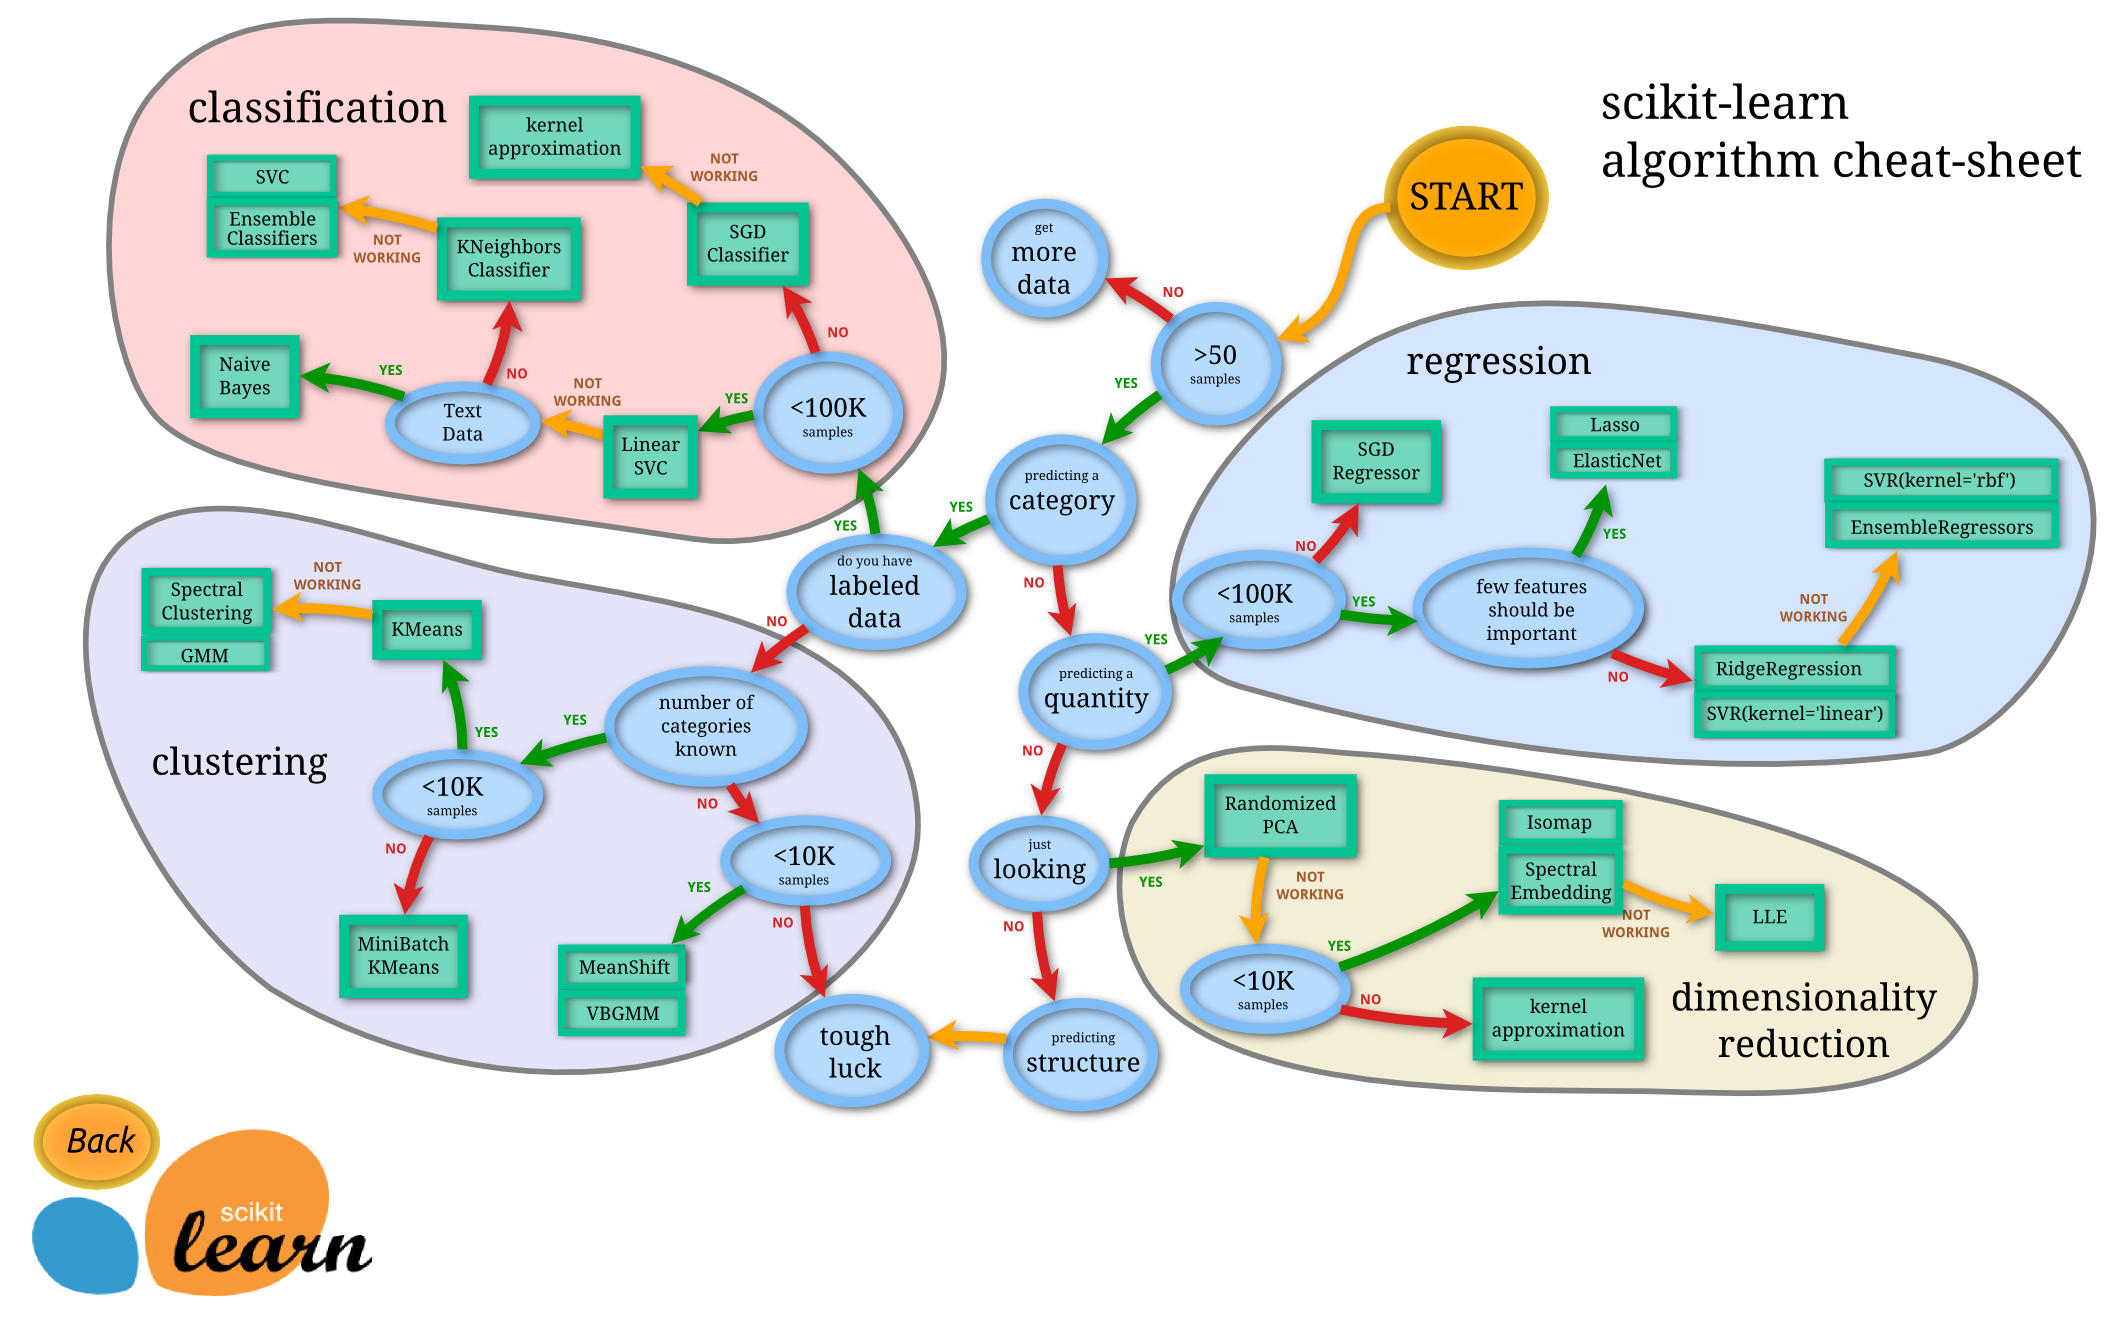

#Desafio 04: Teste outras problemas (perguntas). 0, 1 ou +.

Neste desafio, vamos criar um modelo que, tomando um composto específico como input, consegue prever se este composto possui 2 ativações MOA.

In [23]:
combinado.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,True
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,True


Vamos alterar a coluna `ativo_moa` para contabilizar duas ou mais ativações ao invés de apenas uma:

In [26]:
combinado['ativo_moa'] = combinado['n_moa'].apply(lambda x: True if x>=2 else False)
combinado.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,False
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,False


Para treinar nosso modelo, vamos remover as colunas categóricas gerando variáveis indicadoras (dummies).

In [28]:
dummy = pd.get_dummies(combinado, columns=['dose', 'tratamento', 'tempo'], drop_first = True)
dummy = dummy.drop(['id', 'composto'], axis=1)
dummy.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,dose_D2,tratamento_com_droga,tempo_48,tempo_72
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,-0.2162,...,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,False,0,1,0,0
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,-0.0455,...,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,0,1,0,1
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,1.0310,...,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,0,1,1,0
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,3.0900,-0.3814,...,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,0,1,1,0
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,-0.0848,...,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,False,1,1,0,1


Note que usamos `drop_first = True` para remover uma das colunas, pois um indicador ser falso automaticamente define a outra categoria como verdadeira `(Ex: dose_D2 = False -> dose_D1 = True)`.

Agora que temos os nossos dados, vamos separá-los em treino e teste e treinar nosso modelo:

In [29]:
X = dummy.drop(['n_moa', 'ativo_moa'], axis=1)
y = dummy['ativo_moa']

In [30]:
from sklearn.ensemble import RandomForestClassifier

X_treino, X_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=42)

modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(X_treino, y_treino)
modelo_randomforest.score(X_teste, y_teste)

0.9515011547344111

Como pode ser visto, nosso modelo possui uma acurrácia de 95%. Para melhor visualizar o desempenho de nosso modelo, vamos utilizar o módulo `sklearn.metrics.plot_roc_curve` para plotar a taxa de Verdadeiros Positivos (resultado correto) contra Falsos Positivos (resultado equivocado):

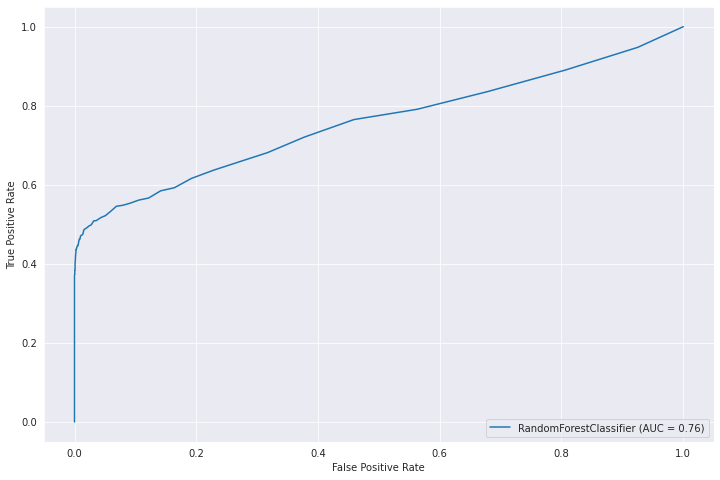

In [32]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(modelo_randomforest, X_teste,y_teste)
plt.show()

Podemos ver que a `Area Under the Curve (AUC`) possui um valor de 0.76. Como este valor é muito próximo de 1, temos certeza que nosso modelo realizou previsões corretas na grande maioria das vezes.

#Desafio 05: Escolha o composto mais utilizado e tente criar um modelo para prever esta label. 


Vamos analisar a coluna `composto` para definir qual é o mais utilizado:

In [33]:
combinado['composto'].value_counts().index[0]

'cacb2b860'

Agora que sabemos o código deste composto, vamos criar outra coluna, `comp`, que assume `True` ou `False` dependendo se o composto é `cacb2b860`.

In [50]:
combinado['comp'] = combinado.composto == 'cacb2b860'
combinado.head()

,id,tratamento,tempo,dose,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,comp
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,False,False
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,False
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,False,False


Com nossa nova coluna, podemos gerar os dados para criar e treinar nosso modelo.

In [68]:
dummy = pd.get_dummies(combinado, columns = ['tratamento', 'tempo', 'dose'])
X = dummy.drop(['id', 'composto', 'n_moa', 'comp'], axis=1)
y = dummy['comp']
dummy.head()

,id,composto,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,...,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,n_moa,ativo_moa,comp,tratamento_com_controle,tratamento_com_droga,tempo_24,tempo_48,tempo_72,dose_D1,dose_D2
0,id_000644bb2,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,...,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,False,False,0,1,1,0,0,1,0
1,id_000779bfc,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,...,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,False,False,0,1,0,0,1,1,0
2,id_000a6266a,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,...,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,True,False,0,1,0,1,0,1,0
3,id_0015fd391,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,...,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,False,False,0,1,0,1,0,1,0
4,id_001626bd3,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,...,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,False,False,0,1,0,0,1,0,1


In [66]:
X.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,...,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,ativo_moa,tratamento_com_controle,com_droga,tempo_24,tempo_48,tempo_72,dose_D1,dose_D2
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,-0.2162,...,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,False,0,1,1,0,0,1,0
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,0.5300,-0.2568,-0.0455,...,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,False,0,1,0,0,1,1,0
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,-0.1219,5.4470,1.0310,...,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,True,0,1,0,1,0,1,0
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,-1.2690,3.0900,-0.3814,...,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,False,0,1,0,1,0,1,0
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,-0.0848,...,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,False,0,1,0,0,1,0,1


In [58]:
y.value_counts()

False    21948
True      1866
Name: comp, dtype: int64

In [59]:
from sklearn.ensemble import RandomForestClassifier

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(X_treino, y_treino)
modelo_randomforest.score(X_teste, y_teste)

1.0

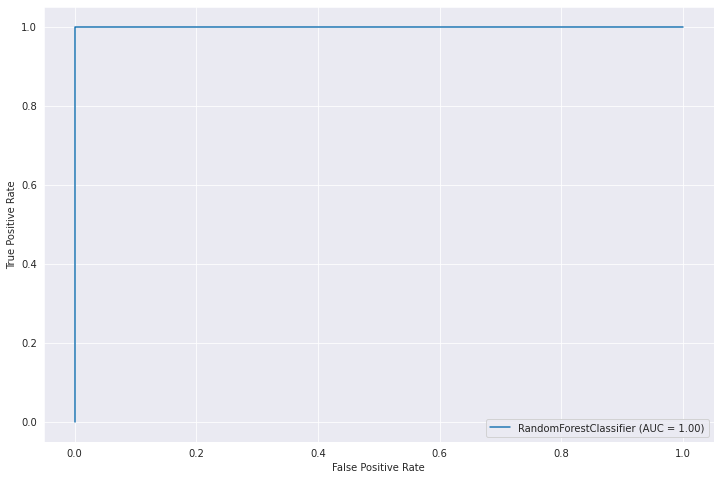

In [61]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(modelo_randomforest, X_teste,y_teste)
plt.show()

Surpreendentemente, os valores de AUC e da acurácia são máximos. Isso se deve pelo fato da feature `tratamento` estar totalmente relacionada ao composto em questão. Como vimos na Aula 1, o composto `cacb2b860` é aplicado apenas nas amostras de controle. Portanto, utilizando um método de Ensemble, basta utilizar a informação do tipo de tratamento. Vamos verificar como o algoritmo lida então, ao retirarmos a feature de `tratamento`.


In [69]:
from sklearn.ensemble import RandomForestClassifier

X = X.drop(['tratamento_com_controle', 'tratamento_com_droga'], axis=1)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(X_treino, y_treino)
modelo_randomforest.score(X_teste, y_teste)

0.9296661767793407

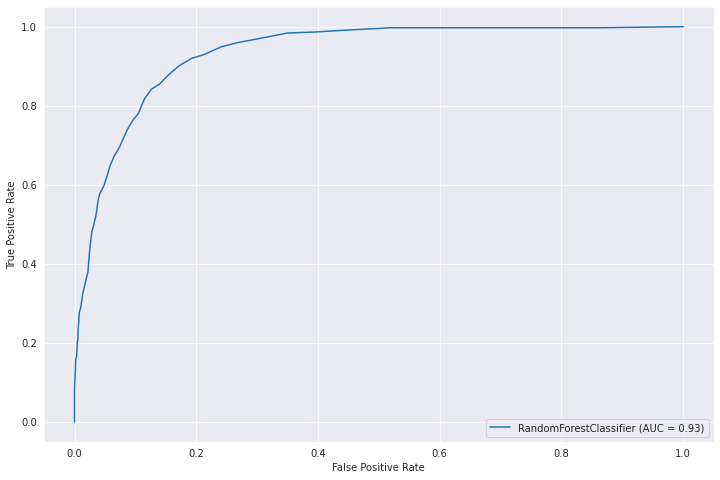

In [72]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(modelo_randomforest, X_teste,y_teste)
plt.show()

Portanto, mesmo sem considerar a feature `tratamento`, nosso modelo pode realizar previsões corretamente sobre o composto `cacb2b860`. Para verificar a vericidade destes resultados, vamos utilizar este modelo no segundo composto mais utilizado.

In [74]:
combinado['composto'].value_counts().index[1]

'87d714366'

In [79]:
combinado['comp2'] = combinado.composto == '87d714366'
dummy = pd.get_dummies(combinado, columns = ['tratamento', 'tempo', 'dose'])
X = dummy.drop(['id', 'composto', 'n_moa', 'comp2'], axis=1)
y = dummy['comp2']

In [80]:
from sklearn.ensemble import RandomForestClassifier

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

modelo_randomforest = RandomForestClassifier()
modelo_randomforest.fit(X_treino, y_treino)
modelo_randomforest.score(X_teste, y_teste)

0.9997900482888935

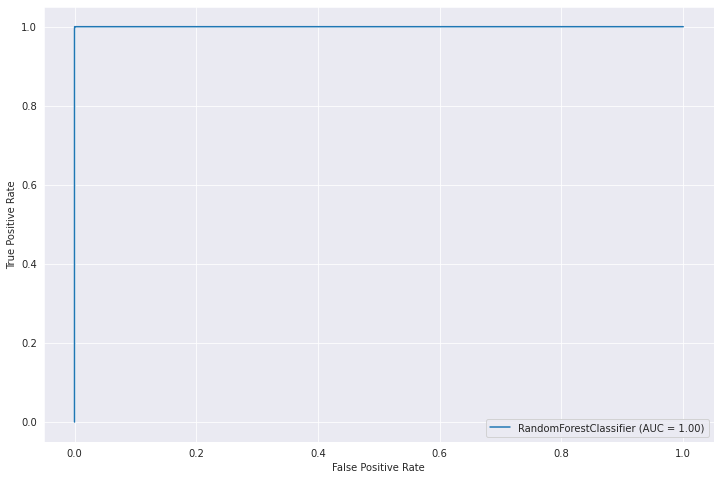

In [81]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(modelo_randomforest, X_teste,y_teste)
plt.show()

Novamente, nosso modelo obteve resultados extremamente satisfatórios. Isso comprova a veracidade de nossos resultados, provando que o modelo é capaz de definir as labels de qualquer composto introduzido como input.

#Desafio 06: Resumo do que você aprendeu com os dados

O conceito de Machine Learning é bem recente, mas nestes últimos anos acabou se tornando uma das ferramentas mais utilizadas em empresas que lidam com quantidades massivas de dados todos os dias. Conforme os humanos vão gernado mais e mais dados todos os dias, precisaremos de modelos melhores e mais otimizados para que possamos trabalhar com eles da melhor forma possível.